# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

STEPS INVOLVED:
* Data Collection
* Data cleaning + EDA for your good (helps in model training)
*  Data Preprocessing
* Feature Extraction
* Model Building
* Model Training and Validation
* Sentiment Classification
* Evaluation and Refinement
* Deployment




### Importing required libraries

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
%pip install wordcloud

### Exploratory Data Analysis

In [105]:
import random

In [106]:
#Load the data

data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [107]:
data['feedback'].value_counts()

,count
feedback,
1,2893
0,257


In [108]:
# Separate the positive and negative classes
positive_class = data[data['feedback'] == 1]
negative_class = data[data['feedback'] == 0]

# Downsample the positive class to match the negative class count
positive_downsampled = positive_class.sample(n=len(negative_class), random_state=42)

# Combine the downsampled positive class with the negative class
data = pd.concat([positive_downsampled, negative_class])

# Shuffle the dataset to mix positive and negative examples
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new balance
print(data['feedback'].value_counts())


feedback
0    257
1    257
Name: count, dtype: int64


In [109]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [110]:
#Check for null values

data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


There is one record with no 'verified_reviews' (null value)

In [111]:
#Getting the record where 'verified_reviews' is null

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
153,2,29-Jun-18,White,NaN,0


In [112]:
#We will drop the null record

data.dropna(inplace=True)

In [113]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (513, 5)


In [114]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [115]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,1,10-Jun-18,Black,"""great product, but useless overall. Too many ...",0,115
1,2,30-Jul-18,Black Dot,"""For the price, the product is nice quality an...",0,742
2,2,30-Jul-18,Configuration: Fire TV Stick,I just think that it's to darn confusing. And ...,0,156
3,5,29-Jul-18,Charcoal Fabric,more compact and a bit better than the original,1,47
4,1,30-Jul-18,Black Dot,This device does not interact with my home fil...,0,89


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [116]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: The echo works fine but then you get indundated with &#34;Things to try&#34;. I am not a 10 year old that needs stimulus to tell me to do things. I found there is no way to turn this off except for .... turning off the screen. If I cannot find a suitable fix for this it goes back.
Length of review : 281
'length' column value : 281


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [117]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [118]:
len(data)

513

In [119]:
#Distinct values of 'rating' and its count

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    199
1    161
2     95
4     42
3     16
Name: count, dtype: int64


Let's plot the above values in a bar graph

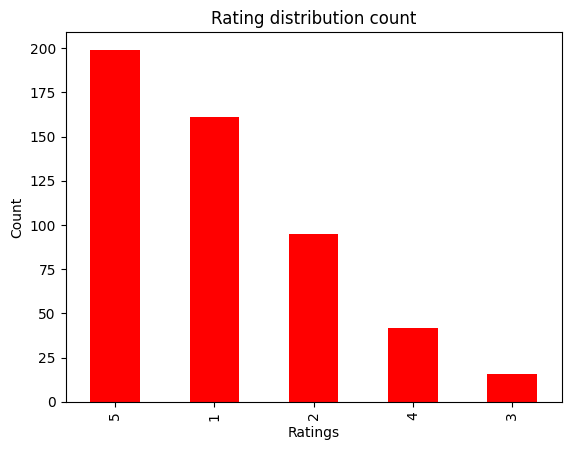

In [120]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [121]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    38.79
1    31.38
2    18.52
4     8.19
3     3.12
Name: count, dtype: float64


Let's plot the above values in a pie chart

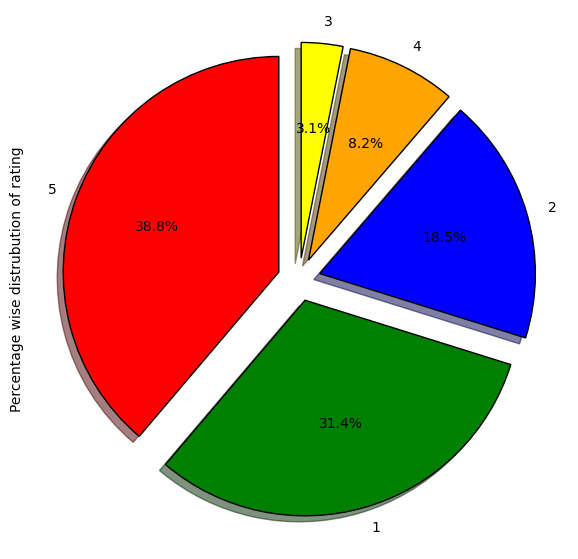

In [122]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [123]:
#Distinct values of 'feedback' and its count

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    257
0    256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [124]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

"For the price, the product is nice quality and has a few nice features. So definitely no complaints there. The reason why I only gave it 3 stars is because the echo dot is not what I thought it was going to be so that may just be buyer error. First, I didn’t know that the product has to be plugged in at all times to work. So I really don’t like that it’s not a stand alone device. Also, the speaker is not very loud so if you are buying it as a Bluetooth speaker, don’t. Lastly, I’m sure the echo dot can do a lot but I haven’t quite figured out how to use it fully but it just kind of seems like an unnecessary device to own, plus setting it up was awful. I would definitely save the money and buy the nicer one that is actually “Alexa”."


In [125]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Nice works great


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

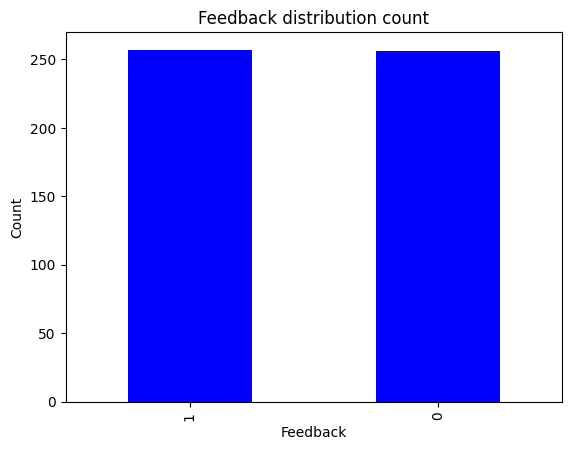

In [126]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [127]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    50.1
0    49.9
Name: count, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

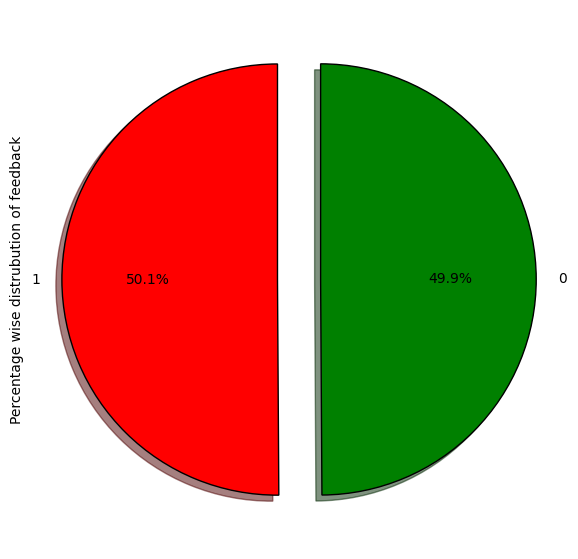

In [128]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [129]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [130]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

,count
rating,
5,199
4,42
3,16


##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [131]:
#Distinct values of 'variation' and its count

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      75
Black                           59
Configuration: Fire TV Stick    51
Black  Spot                     51
Charcoal Fabric                 50
Black  Plus                     49
Black  Show                     47
White  Dot                      26
White                           24
White  Show                     18
White  Spot                     18
Sandstone Fabric                15
White  Plus                     15
Heather Gray Fabric             13
Oak Finish                       1
Walnut Finish                    1
Name: count, dtype: int64


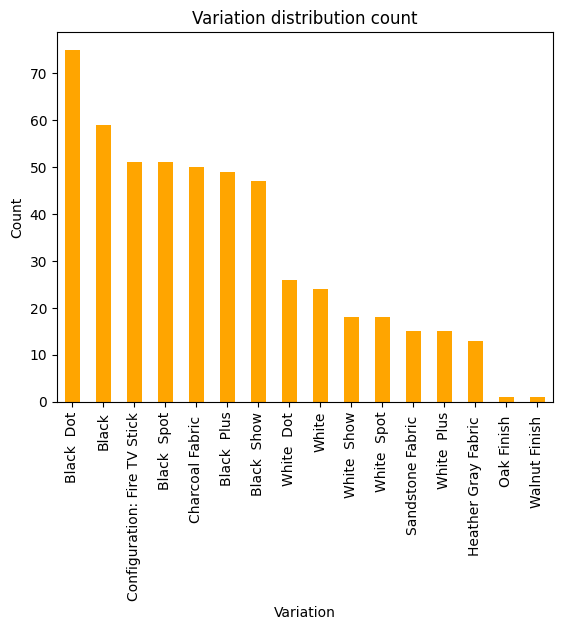

In [132]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [133]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      14.62
Black                           11.50
Configuration: Fire TV Stick     9.94
Black  Spot                      9.94
Charcoal Fabric                  9.75
Black  Plus                      9.55
Black  Show                      9.16
White  Dot                       5.07
White                            4.68
White  Show                      3.51
White  Spot                      3.51
Sandstone Fabric                 2.92
White  Plus                      2.92
Heather Gray Fabric              2.53
Oak Finish                       0.19
Walnut Finish                    0.19
Name: count, dtype: float64


Mean rating according to variation

In [134]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,2.627119
Black Dot,3.133333
Black Plus,2.857143
Black Show,3.361702
Black Spot,2.705882
Charcoal Fabric,3.980000
Configuration: Fire TV Stick,2.980392
Heather Gray Fabric,4.076923
Oak Finish,5.000000


Let's analyze the above ratings

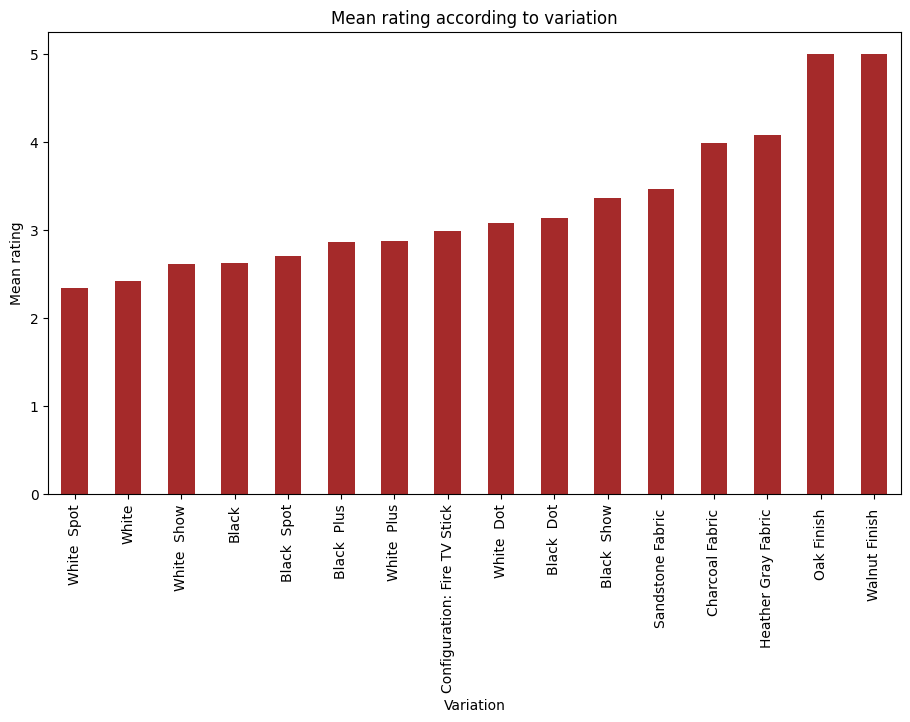

In [135]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [136]:
data['length'].describe()

,length
count,513.000000
mean,166.615984
std,199.766824
min,1.000000
25%,35.000000
50%,99.000000
75%,210.000000
max,1688.000000


Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

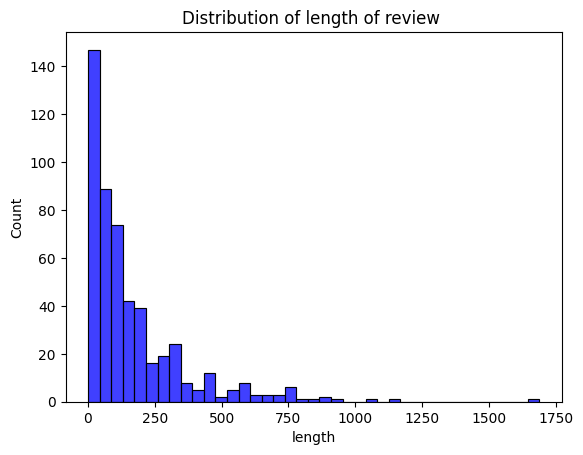

In [137]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

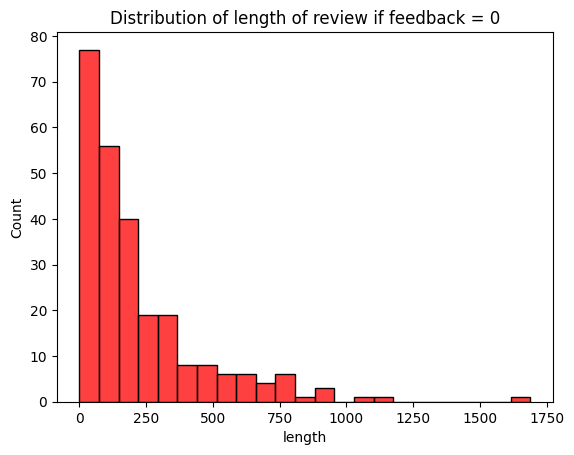

In [138]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

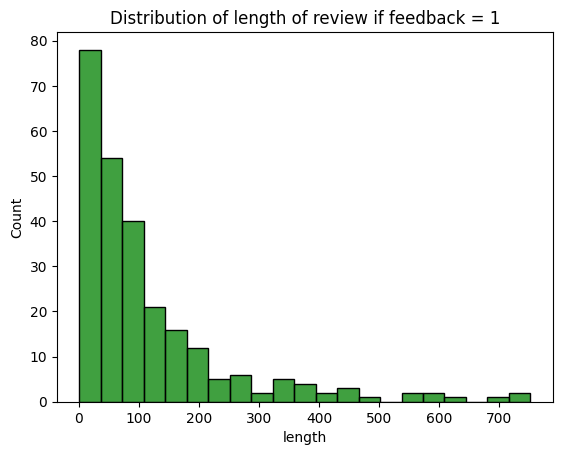

In [139]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

feedback: 0
0      1
1      2
2      2
4      1
7      2
      ..
503    1
505    1
510    1
511    2
512    1
Name: rating, Length: 256, dtype: int64
feedback: 1
3      5
5      5
6      5
9      5
13     5
      ..
506    5
507    5
508    5
509    5
513    5
Name: rating, Length: 257, dtype: int64


feedback
0    1.371094
1    4.712062
Name: rating, dtype: float64


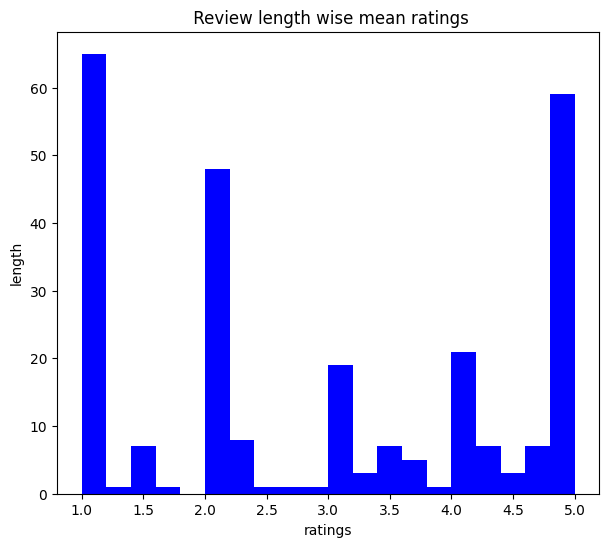

In [140]:
for feedback,group in data.groupby('feedback')['rating']:
    print(f"feedback: {feedback}")
    print(group)
print("\n")

print(data.groupby('feedback')['rating'].mean())

data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [141]:
#count vectorizer-->converts text data into numerical representations for machine to understand!!
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)   #returns the word matrix
#Fit: learns the vocabulary (set of unique words),Transform: converts text data into a matrix of token counts based on the learned vocabulary.

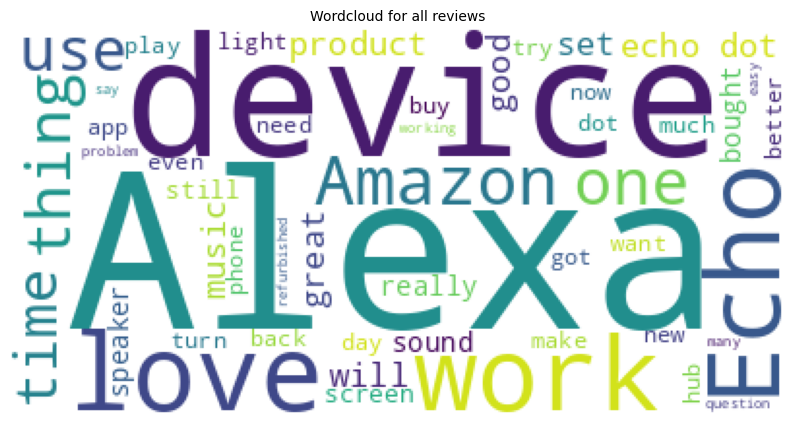

In [142]:
# Generate the word cloud(dictionary of words) from the combined reviews!!

# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [143]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


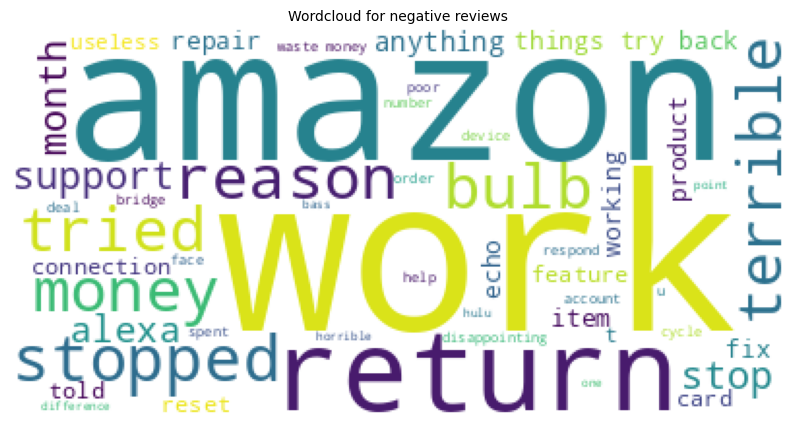

In [144]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

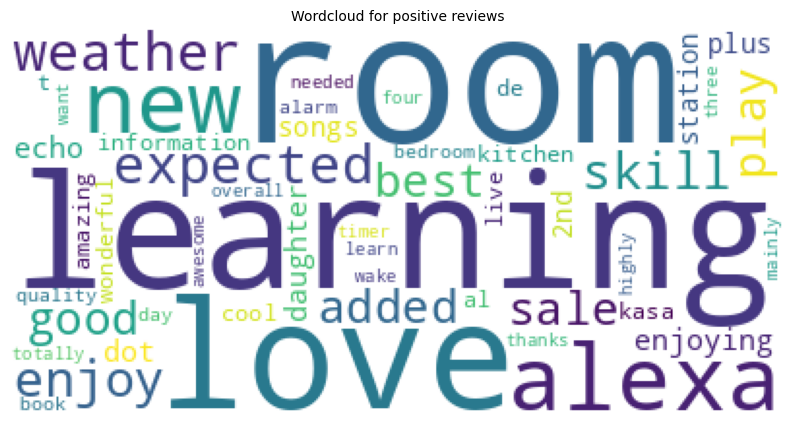

In [145]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [146]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  #re-->regular exp lib
  #re.sub('[^a-zA-Z]', ' ', ...) replaces any character that is not a letter (a-z, A-Z) with a space.
  #This helps to clean the text by removing punctuation and numbers
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]   #performs stemming on each word in the review.
  review = ' '.join(review)   #add space
  corpus.append(review)

print(corpus)

['great product useless overal mani unnecessari featur unless smart home need', 'price product nice qualiti nice featur definit complaint reason gave star echo dot thought go may buyer error first know product plug time work realli like stand alon devic also speaker loud buy bluetooth speaker lastli sure echo dot lot quit figur use fulli kind seem like unnecessari devic plu set aw would definit save money buy nicer one actual alexa', 'think darn confus part would tri work like thought would', 'compact bit better origin', 'devic interact home fill appl devic disappoint', 'nice work great', 'love simpl set love fact answer question bought one everybodi famili like jetson', 'weak sound compar googl home mini sound bad also need prime small select music need prime music play everyth also get two need prime famili music play music think lame need famili plan use multipl devic', 'got great sound bass work time still hot miss recogn thing', 'awesom life changer serious abl start morn alexa wa

**Feature extraction:**
Using Count Vectorizer to create bag of words : BOW--> text document is represented as an unordered collection (or "bag") of its words, disregarding grammar, word order, and sentence structure.


In [178]:
cv = CountVectorizer(max_features = 1465)

#Storing independent and dependent variables in X and y
#learns the vocabulary from the corpus (a list of processed reviews) and transforms the text data into a sparse matrix of counts.
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

cv = CountVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
cv.fit(corpus)  # Fit on the updated corpus

pickle.dump(cv, open("countVectorizer.pkl", "wb"))  # Save the new vectorizer

In [148]:
#Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [149]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(X)
print(y)

X shape: (513, 1465)
y shape: (513,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0
 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1
 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0
 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1
 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1
 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0
 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0
 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0
 0 1 1 1 0 0 1 0 0

Splitting data into train and test set with 30% data with testing.

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

ValueError: Found input variables with inconsistent numbers of samples: [1, 513]

In [151]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 6
X test max value: 5


We'll scale X_train and X_test so that all values are between 0 and 1.

*scale features in a dataset.*

**Why Scaling is Important**
* Feature Scale: Many machine learning algorithms, especially those based on distances (e.g., K-Nearest Neighbors, Support Vector Machines) or gradient descent optimization (e.g., logistic regression, neural networks), are sensitive to the scale of the features. Features with larger ranges can disproportionately influence the model's performance.

* Better Model Performance: Properly scaled features can lead to improved model accuracy and better generalization to unseen data.

In [152]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [153]:
#Saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

When deploying a model into a production environment, you will often need to preprocess input data in the same way it was preprocessed during training. Saving the scaler allows you to easily integrate this step into your deployment pipeline.

#### Random Forest

In [154]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [155]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9805013927576601
Testing Accuracy : 0.7662337662337663


we are getting low bias low variance thus good sign!!

In [156]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [157]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

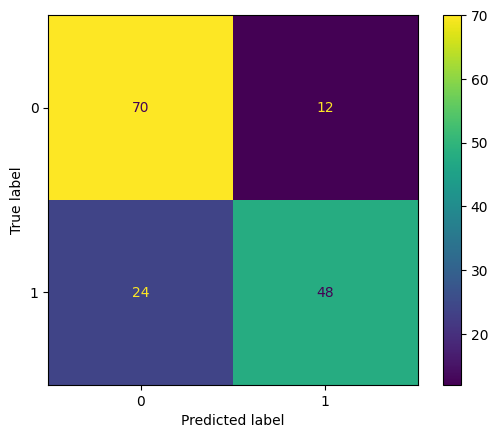

In [158]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [159]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.7578571428571428
Standard Variance : 0.07718061163789255


Applying grid search to get the optimal parameters on random forest

In [160]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [161]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [162]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [163]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 97.91045934202359
Cross validation mean accuracy on test set : 73.9546477343265
Accuracy score for test set : 0.7662337662337663


#### XgBoost

In [164]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [165]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9275766016713092
Testing Accuracy : 0.7532467532467533


In [166]:
y_preds = model_xgb.predict(X_test)

In [167]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[71 11]
 [27 45]]


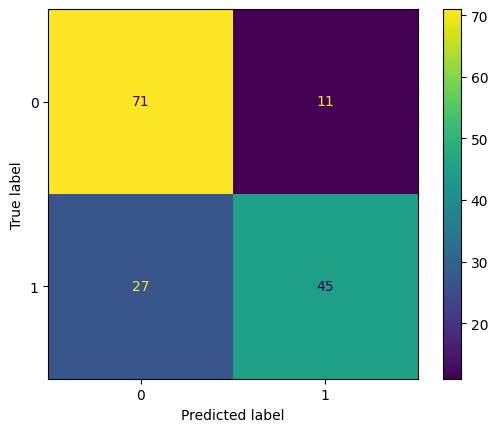

In [168]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [169]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [170]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [171]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9805013927576601
Testing Accuracy : 0.7272727272727273


overfitting (low bias high var)

In [172]:
y_preds = model_dt.predict(X_test)

In [173]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[64 18]
 [26 46]]


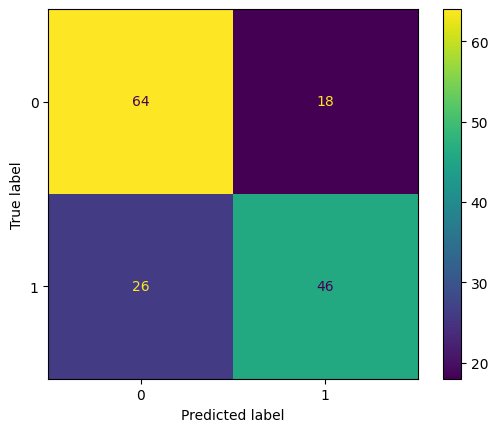

In [174]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

TN(40-1st Quadrant): actual feedback was 0(neg) and model predicted it as 0(neg) as well

moving forward with x gradient boost algo as predicting model(pos/neg) for reviews

In [175]:
corpus = []
stemmer = PorterStemmer()

# Step 1: Preprocess the text
review = re.sub("[^a-zA-Z]", " ", "Bad product")
review = review.lower().split()
review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
review = " ".join(review)
corpus.append(review)

# Debugging: Print preprocessed text
print("Preprocessed Text:", corpus)

# Step 2: Transform using CountVectorizer
X_prediction = cv.transform(corpus).toarray()
print("CountVectorizer Output:", X_prediction)

# Step 3: Scale the features
X_prediction_scl = scaler.transform(X_prediction)
print("Scaled Features:", X_prediction_scl)

# Step 4: Predict the probability and choose the class
y_predictions = model_dt.predict_proba(X_prediction_scl)
print("Predicted Probabilities:", y_predictions)

# Step 5: Get the class with the highest probability
y_predictions = y_predictions.argmax(axis=1)[0]
print("Predicted Class:", y_predictions)



Preprocessed Text: ['bad product']
CountVectorizer Output: [[0 0 0 ... 0 0 0]]


ValueError: X has 5000 features, but MinMaxScaler is expecting 1465 features as input.